In [1]:
import pandas as pd
import os 
import subprocess
import warnings 
from src.files import XMLFile, FASTAFile, GBFFFile
from src import get_genome_id
import src 
from src.dataset import Dataset
from utils import * 
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import dataframe_image as dfi
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
import pingouin

%load_ext autoreload 
%autoreload 2

In [2]:
# genome_metadata_df = load_genome_metadata()
pred_df = load_predict('../data/predict/campylobacterota_dataset_test_predict.csv', model_name='campylobacterota_esm_650m_gap_v1')
pred_df = pred_df.merge(pd.read_csv('../data/campylobacterota_dataset_test.csv', dtype={'top_hit_partial':str, 'query_partial':str}, index_col=0, low_memory=False).drop(columns=['label']), left_index=True, right_index=True, how='left')

In [3]:
def table_1(path:str=None):

    # model_names = [model_name.replace('.pkl', '') for model_name in os.listdir('../models/')]
    # model_names = ['campylobacterota_esm_650m_gap_v2', 'campylobacterota_esm_650m_gap_v1']
    model_names = ['campylobacterota_esm_650m_gap_v1']
    table_df = list()

    for model_name in model_names:
        pred_df = load_predict('../data/predict/campylobacterota_dataset_test_predict.csv', model_name=model_name)
        row = dict()
        row['feature type'] = re.search('(esm_650m_gap|pt5_3b_gap|esm_3b_gap)', model_name).group(1) 
        row['model_name'] = model_name
        row.update(pred_df.confusion_matrix.value_counts().to_dict())
        row['accuracy'] = np.round(balanced_accuracy_score(pred_df.label, pred_df.model_label), 4)
        table_df.append(row)
    return pd.DataFrame(table_df).set_index('model_name')

table_1().sort_values('false positive')

# It's actually doing much worse than random on the negative instances, which implies to me that something is going on with the model training. 

,feature type,true positive,false negative,true negative,false positive,accuracy
model_name,,,,,,
campylobacterota_esm_650m_gap_v1,esm_650m_gap,59471,2882,137,13,0.9336


/home/prichter/Documents/tripy/notebooks/utils.py:72: UserWarning: get_lengths: Not all gene lengths are divisible by three.
  warnings.warn('get_lengths: Not all gene lengths are divisible by three.')
/home/prichter/Documents/tripy/notebooks/utils.py:72: UserWarning: get_lengths: Not all gene lengths are divisible by three.
  warnings.warn('get_lengths: Not all gene lengths are divisible by three.')


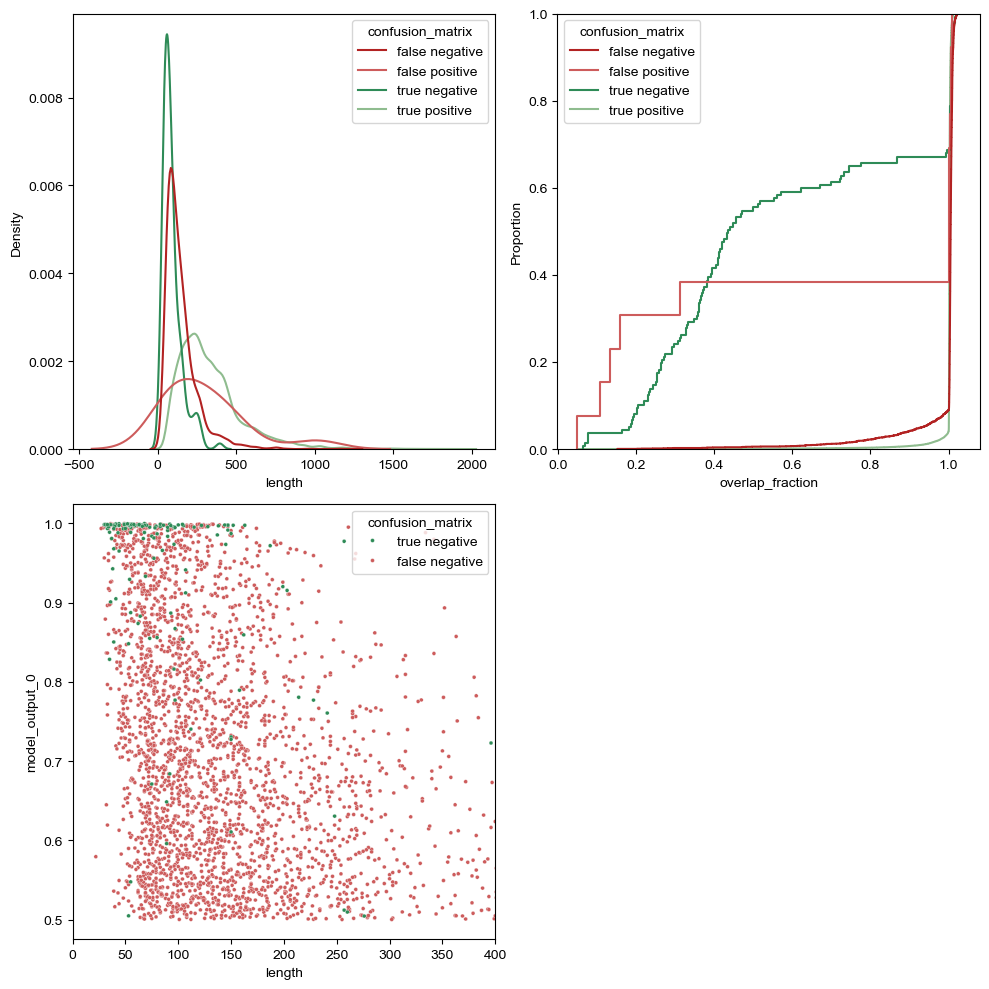

In [ ]:
# The thing I am most concerned about are the false negatives. What sequences is the model struggling on?
# Maybe there is some connection to overlap length?

pred_df[pred_df.confusion_matrix == 'false negative'][['top_hit_feature', 'top_hit_pseudo', 'top_hit_product']].value_counts()

fig = plt.figure(figsize=(10, 10), layout='tight')
grid = GridSpec(nrows=2, ncols=2, figure=fig)
ax_a, ax_b, ax_c = fig.add_subplot(grid[0, 0]), fig.add_subplot(grid[0, 1]), fig.add_subplot(grid[1, 0])

ax_a_df = pred_df[['confusion_matrix']].copy()
ax_a_df['length'] = get_lengths(pred_df, top_hit=False)
colors = ['firebrick', 'indianred', 'seagreen', 'darkseagreen']
hue_order = ['false negative', 'false positive', 'true negative', 'true positive']
sns.kdeplot(ax=ax_a, data=ax_a_df, x='length', hue='confusion_matrix', palette=colors, hue_order=hue_order, common_norm=False)

ax_b_df = pred_df[['confusion_matrix']].copy()
ax_b_df['length'] = get_lengths(pred_df, top_hit=False, units='nt')
ax_b_df['overlap_length'] = pred_df['overlap_length']
ax_b_df['overlap_fraction'] = ax_b_df.overlap_length / ax_b_df.length # This is relative to the query sequence.
colors = ['firebrick', 'indianred', 'seagreen', 'darkseagreen']
hue_order = ['false negative', 'false positive', 'true negative', 'true positive'] 
sns.ecdfplot(ax=ax_b, data=ax_b_df, x='overlap_fraction', hue='confusion_matrix', palette=colors, hue_order=hue_order) #, common_norm=False)

# Maybe adjusting the threshold would help?
# Recall is the ratio of correct predictions to the total number of true members of that class. 
# Precision is the ratio of correct predictions to the total number of model-predicted members of that class. 
# threshold = np.linspace(0, 1, 10)
# ax_c_df = pd.DataFrame({'threshold':list(threshold)}) #  + list(threshold)})
# ax_c_df['precision'] = [precision(pred_df, threshold=x, class_=0) for x in threshold] # + [precision(pred_df, threshold=x, class_=1) for x in threshold]
# ax_c_df['recall'] = [recall(pred_df, threshold=x, class_=0) for x in threshold] # + [recall(pred_df, threshold=x, class_=1) for x in threshold]
# ax_c_df['label'] = ['spurious'] * len(threshold) # + ['real'] * len(threshold)
# ax_c = sns.lineplot(data=df, x='threshold', y='precision', ax=ax_c, label=label, legend=False, color='gray')
# ax_c = sns.lineplot(data=df, x='threshold', y='recall', ax=ax_c.twinx(), label=label, legend=False, color='gray', ls=':', lw=3)

ax_c_df = pred_df[['model_output_0', 'confusion_matrix']].copy()
ax_c_df['length'] = pred_df.seq.apply(len)
ax_c_df = ax_c_df[pred_df.confusion_matrix.isin(['false negative', 'true negative'])].copy()
colors = ['seagreen', 'indianred']
hue_order = ['true negative', 'false negative']
sns.scatterplot(data=ax_c_df.sort_values('confusion_matrix', ascending=True), x='length', y='model_output_0', s=8, ax=ax_c, hue='confusion_matrix', hue_order=hue_order, palette=colors)
ax_c.set_xlim(xmin=0, xmax=400)

# So weird, seems like lowering the threshold is making the precision increase?
# This means that when the model predicts more members of the 0 class, there are relatively more correct predictions to total 
# negative predictions.  
plt.show()

# Looking at the third planel explains the weirdness with the precision. The ones it's getting right it is very sure about

In [6]:
pred_df[pred_df.confusion_matrix == 'false negative'][['top_hit_product', 'exact_match']].value_counts()

top_hit_product                                  exact_match
hypothetical protein                             True           975
                                                 False          195
DUF4006 family protein                           True            34
BspA family leucine-rich repeat surface protein  True            29
DUF2018 family protein                           True            29
                                                               ... 
universal stress protein                         False            1
3-oxoadipyl-CoA thiolase                         False            1
3'-5' exonuclease                                False            1
2OG-Fe dioxygenase family protein                False            1
(2Fe-2S)-binding protein                         True             1
Name: count, Length: 804, dtype: int64

In [7]:
ref_df = load_ref()

# Remove genome 'GCF_000009085.1' from training set. Maybe just exclude everything that didn't use PGAP. 
# Filter out sequences with 'X' in them -- when does Prodigal do this?

TypeError: 'NoneType' object is not iterable

In [ ]:
ref_df[(ref_df.top_hit_evidence_type == 'ab initio prediction') & ref_df.top_hit_pseudo][['top_hit_note', 'top_hit_inference']]
ref_df[(ref_df.top_hit_evidence_type == 'ab initio prediction') & ref_df.top_hit_pseudo].top_hit_note[0]

/tmp/ipykernel_1277399/2826397453.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ref_df[(ref_df.top_hit_evidence_type == 'ab initio prediction') & ref_df.top_hit_pseudo].top_hit_note[0]


'incomplete; too short partial abutting assembly gap; missing C-terminus; Derived by automated computational analysis using gene prediction method: GeneMarkS-2+.'

In [ ]:
df = ref_df[ref_df.top_hit_genome_id == 'GCF_013201625.1']
df[df.spurious][['top_hit_product', 'top_hit_note', 'top_hit_start', 'same_strand', 'top_hit_stop', 'query_start',  'query_stop', 'overlap_length', 'query_length', 'top_hit_length']]
# df[df.spurious]['top_hit_inference'][0]

,top_hit_product,top_hit_note,top_hit_start,same_strand,top_hit_stop,query_start,query_stop,overlap_length,query_length,top_hit_length
id,,,,,,,,,,
NZ_CP053839.1_401,PAS domain-containing protein,Derived by automated computational analysis us...,410412,True,410855,410348,410443,32,96,444
NZ_CP053839.1_655,hypothetical protein,Derived by automated computational analysis us...,663388,True,663657,663617,663736,41,120,270


In [ ]:
ref_df[ref_df.top_hit_partial.isin(['01', '10']) & ref_df.spurious][['top_hit_note', 'top_hit_pseudo', 'top_hit_product', 'top_hit_overlap_fraction', 'query_overlap_fraction', 'query_start', 'query_stop', 'top_hit_start', 'top_hit_stop', 'overlap_start', 'overlap_stop', 'top_hit_seq', 'query_seq', 'top_hit_feature', 'overlap_length', 'query_strand', 'top_hit_strand', 'real']]

,top_hit_note,top_hit_pseudo,top_hit_product,top_hit_overlap_fraction,query_overlap_fraction,query_start,query_stop,top_hit_start,top_hit_stop,overlap_start,overlap_stop,top_hit_seq,query_seq,top_hit_feature,overlap_length,query_strand,top_hit_strand,real
id,,,,,,,,,,,,,,,,,,
NZ_MDSU01000001.1_1,Derived by automated computational analysis us...,False,23S ribosomal RNA,0.712500,1.000000,1,399,1,560,1,399,none,TVRGTPRSDTKVGLSDPVVSVWKGHRSTDKRYSGDNRLIPPKSSYR...,rRNA,399,1,1,False
NZ_JBHRZO010000012.1_13,Derived by automated computational analysis us...,False,23S ribosomal RNA,0.150690,1.000000,8201,8626,8036,10862,8201,8626,none,MAVGNRQLSVMAQASLTARETTQAETKVGHSDPVVLVWKSHRSKDK...,rRNA,426,-1,-1,False
NZ_JBHRZO010000012.1_14,Derived by automated computational analysis us...,False,23S ribosomal RNA,0.066855,1.000000,10467,10655,8036,10862,10467,10655,none,MSKNNQNDRKSSINIHDYDHGKPLRICPKCGEEKPIEEFGYRNNDG...,rRNA,189,-1,-1,False
NZ_JBHRZO010000030.1_4,Derived by automated computational analysis us...,False,HipA domain-containing protein,0.065272,1.000000,2528,2605,1411,2605,2528,2605,SYPKIIRVICRCVVALLRSGGGRMAENFSQKWIAQYNKEVDEYNVK...,KLPKDYKSNMQVCSGFIEEWGGKNG,CDS,78,-1,-1,False
NZ_JBHRZO010000069.1_1,frameshifted; internal stop; incomplete; missi...,True,RNA-guided endonuclease InsQ/TnpB family protein,0.322767,1.000000,519,854,1,1041,519,854,none,MQELVERIDKAYKKFFKKQGRPPRFKKVTNYQSFTFSQCGYKIKDS...,CDS,336,-1,-1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NZ_NBIU01000131.1_2,incomplete; too short partial abutting assembl...,True,hypothetical protein,0.213592,0.240437,163,345,1,206,163,206,none,MQETRMKVIILRLDKAVRLALTIHSPSNWGILLLHFRYQPYLNNFN...,CDS,44,1,1,False
NZ_CDMG01000002.1_565,incomplete; too short partial abutting assembl...,True,hypothetical protein,0.024778,0.055008,574945,576162,576096,578799,576096,576162,none,MTLKGWGVPPPPPXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,CDS,67,1,-1,False
NZ_CDMG01000006.1_10,incomplete; too short partial abutting assembl...,True,hypothetical protein,0.032691,0.055556,13353,14756,11045,13430,13353,13430,none,MLPLGLVSPSPSPLVVSVLGFWGSLPXXXXXXXXXXXXXXXXXXXX...,CDS,78,1,-1,False


In [ ]:
def table_2(pred_df:pd.DataFrame, path:str='../figures/filter-table_1.png'):
    table_df = dict()

    table_df['accuracy'] = pred_df.groupby('genome_id').apply(lambda df : balanced_accuracy_score(df.label, df.model_label) , include_groups=False)
    
    for confusion_matrix, df in pred_df.groupby('confusion_matrix'):
        table_df[confusion_matrix] = df.groupby('genome_id').apply(len, include_groups=False)
    table_df = pd.DataFrame(table_df).fillna(0)
    table_df = table_df.sort_values('false negative', ascending=False)
    dfi.export(table_df.iloc[:50], path)
    return table_df


table_2(pred_df)

/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
124505 bytes written to file /tmp/tmp8xm6f3fv/temp.png


,accuracy,false negative,false positive,true negative,true positive
genome_id,,,,,
GCF_000364285.1,0.935224,249,0.0,4.0,1673
GCF_003364195.1,0.933941,239,0.0,2.0,1570
GCF_000765905.2,0.935806,199,0.0,2.0,1351
GCF_003660395.1,0.881260,137,1.0,7.0,1081
GCF_025998455.1,0.836739,131,2.0,7.0,1125
GCF_013374215.1,0.905293,131,2.0,19.0,1260
GCF_000259275.1,0.957271,124,0.0,3.0,1327
GCF_014905115.1,0.975511,91,0.0,4.0,1767
GCF_009690845.1,0.801688,90,1.0,2.0,1332


In [ ]:
pred_df[pred_df.confusion_matrix == 'false positive'].ref_product.value_counts()
pred_df[pred_df.confusion_matrix == 'true negative'].ref_product.value_counts()

pred_fp_df = pred_df[pred_df.confusion_matrix == 'false positive']
pred_tn_df = pred_df[pred_df.confusion_matrix == 'true negative']

pred_df[(pred_df.ref_product == 'hypothetical protein') & pred_df.ref_seq.isnull()][['ref_pseudo', 'ref_product', 'partial', 'ref_evidence_type', 'ref_partial']]
pred_fp_df[(pred_fp_df.ref_product == 'hypothetical protein')].value_counts('ref_evidence_type')
pred_tn_df[(pred_tn_df.ref_product == 'hypothetical protein')].value_counts('ref_evidence_type')

ref_evidence_type
ab initio prediction      6368
similar to AA sequence    3647
protein motif              202
profile                     14
Name: count, dtype: int64

In [ ]:
train_df = pd.read_csv('../data/filter_dataset_train.csv', index_col=0)
test_df = pd.read_csv('../data/filter_dataset_test.csv', index_col=0)

x_train, y_train = train_df.seq.apply(len).values, train_df.label.values
x_test, y_test = test_df.seq.apply(len).values, test_df.label.values

model = LogisticRegression(class_weight='balanced', C=0.001, tol=1e-8)
model.fit(x_train.reshape(-1, 1), y_train)

y_test_pred = model.predict(x_test.reshape(-1, 1))
y_train_pred = model.predict(x_train.reshape(-1, 1))

print('Balanced test accuracy:', balanced_accuracy_score(y_test, y_test_pred.ravel()))
print('Balanced train accuracy:', balanced_accuracy_score(y_train, y_train_pred.ravel()))

Balanced test accuracy: 0.7081700317418668
Balanced train accuracy: 0.70982568099759


In [ ]:
# train_metadata_df = pd.read_csv('../data/filter_dataset_train.csv', index_col=0, low_memory=False)
# test_metadata_df = pd.read_csv('../data/filter_dataset_test.csv', index_col=0, low_memory=False)

np.intersect1d(test_metadata_df.index, train_metadata_df.index)

array(['NC_000962.3_1', 'NC_000962.3_10', 'NC_000962.3_100', ...,
       'NZ_WNKU01000117.1_2', 'NZ_WNKU01000123.1_1',
       'NZ_WNKU01000130.1_1'], shape=(331385,), dtype=object)

In [ ]:
len(train_metadata_df)

331385

In [ ]:
len(pd.read_hdf('../data/filter_dataset_test.h5', key='metadata'))